In [13]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import time
import h5py
import torch
import numpy as np
import diffusion_pde as dpde
import matplotlib.pyplot as plt
from pathlib import Path
from omegaconf import OmegaConf
from hydra import initialize_config_dir, compose

# Inspect the data
The following cells are designed to check:
1. The data is correct, i.e. no extremely large values, infs, NaNs
2. No direct overlap between test and train data
3. Check that time steps lines up correctly
4. Visual inspection of the data

In [14]:
data_dir = dpde.utils.get_repo_root() / "data" 

tscales = ["lineart", "logt"]

data_paths = {tscale: {"train": data_dir / f"heat_{tscale}.hdf5",
                       "test": data_dir / f"heat_{tscale}_validate.hdf5"}
              for tscale in tscales}

for tscale, paths in data_paths.items():
    print(f"{tscale} data:\ttrain path exists: {paths['train'].exists()}, test path exists: {paths['test'].exists()}")

lineart data:	train path exists: True, test path exists: True
logt data:	train path exists: True, test path exists: True


In [21]:
# Assert that data doesnt contain erroneous values
for tscale, paths in data_paths.items():
    for split, path in paths.items():
        print(f"Checking {tscale} {split} data at {path}...")
        with h5py.File(path, 'r') as f:
            U = f['U'][:]   # shape (N, C, H, W, T)
            A = f['A'][:]   # shape (N, C, H, W)
        data = np.concatenate([U, A[..., np.newaxis]], axis=-1)  # concatenate along channel
        if np.any(np.isnan(data)):
            print(f"NaN values found in {tscale} {split} data.")
        if np.any(np.isinf(data)):
            print(f"Inf values found in {tscale} {split} data.")
        if np.max(np.abs(data)) > 1e2:
            print(f"Extremely large values found in {tscale} {split} data: max abs value = {np.max(np.abs(data))}")
        print(f"{tscale} {split} data check complete. No issues found.")
del U, A, data

Checking lineart train data at /home/s204790/dynamical-pde-diffusion/data/heat_lineart.hdf5...
lineart train data check complete. No issues found.
Checking lineart test data at /home/s204790/dynamical-pde-diffusion/data/heat_lineart_validate.hdf5...
lineart test data check complete. No issues found.
Checking logt train data at /home/s204790/dynamical-pde-diffusion/data/heat_logt.hdf5...
logt train data check complete. No issues found.
Checking logt test data at /home/s204790/dynamical-pde-diffusion/data/heat_logt_validate.hdf5...
logt test data check complete. No issues found.


In [22]:
# Check for overlap between train and test data
# We assume that labels uniquely identify samples
for tscale, paths in data_paths.items():
    with h5py.File(paths['train'], 'r') as f_train, h5py.File(paths['test'], 'r') as f_test:
        labels_train = f_train['labels'][:]  # shape (N_train, num_labels)
        labels_test = f_test['labels'][:]    # shape (N_test, num_labels
    overlap = np.intersect1d(labels_train.view([('', labels_train.dtype)] * labels_train.shape[1]),
                                labels_test.view([('', labels_test.dtype)] * labels_test.shape[1]))
    if overlap.size > 0:
        print(f"Overlap found in {tscale} data between train and test sets: {overlap}")
    else:
        print(f"No overlap found in {tscale} data between train and test sets.")
del labels_train, labels_test, overlap

No overlap found in lineart data between train and test sets.
No overlap found in logt data between train and test sets.


In [ ]:
# check time steps

all_data_paths = [path for paths in data_paths.values() for path in paths.values()]

for path in all_data_paths:
    with h5py.File(path, 'r') as f:
        time_steps = f['t_steps'][:]  # shape (T,)
        T = f.attrs["T"]
    if not np.all(np.diff(time_steps) > 0):
        print(f"Time steps in {path} are not strictly increasing: {time_steps}")
    else:
        print(f"Time steps in {path} are valid and strictly increasing.")
    if not np.allclose(time_steps[0], 0):
        print(f"First time step in {path} is not zero: {time_steps[0]}")
    if not np.allclose(time_steps[-1], T, atol=1e-3):
        print(f"Last time step in {path} does not match T={T}: {time_steps[-1]}")
    print(f"Time steps in {path} check complete.")
del time_steps, T

Time steps in /home/s204790/dynamical-pde-diffusion/data/heat_lineart.hdf5 are valid and strictly increasing.
Time steps in /home/s204790/dynamical-pde-diffusion/data/heat_lineart.hdf5 check complete.
Time steps in /home/s204790/dynamical-pde-diffusion/data/heat_lineart_validate.hdf5 are valid and strictly increasing.
Time steps in /home/s204790/dynamical-pde-diffusion/data/heat_lineart_validate.hdf5 check complete.
Time steps in /home/s204790/dynamical-pde-diffusion/data/heat_logt.hdf5 are valid and strictly increasing.
Time steps in /home/s204790/dynamical-pde-diffusion/data/heat_logt.hdf5 check complete.
Time steps in /home/s204790/dynamical-pde-diffusion/data/heat_logt_validate.hdf5 are valid and strictly increasing.
Time steps in /home/s204790/dynamical-pde-diffusion/data/heat_logt_validate.hdf5 check complete.


In [34]:
lbls = np.array([1])
label_str = "(" + "".join([f"{lbl}, " for lbl in lbls]) + ")"
label_str

'(1, )'

Visual inspection of data in /home/s204790/dynamical-pde-diffusion/data/heat_lineart.hdf5...


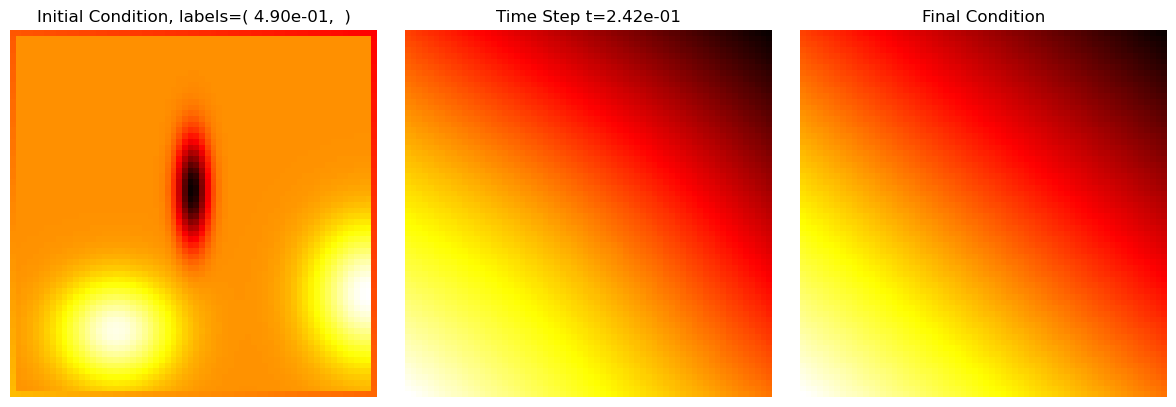

Visual inspection of data in /home/s204790/dynamical-pde-diffusion/data/heat_lineart.hdf5 complete.
Visual inspection of data in /home/s204790/dynamical-pde-diffusion/data/heat_lineart_validate.hdf5...


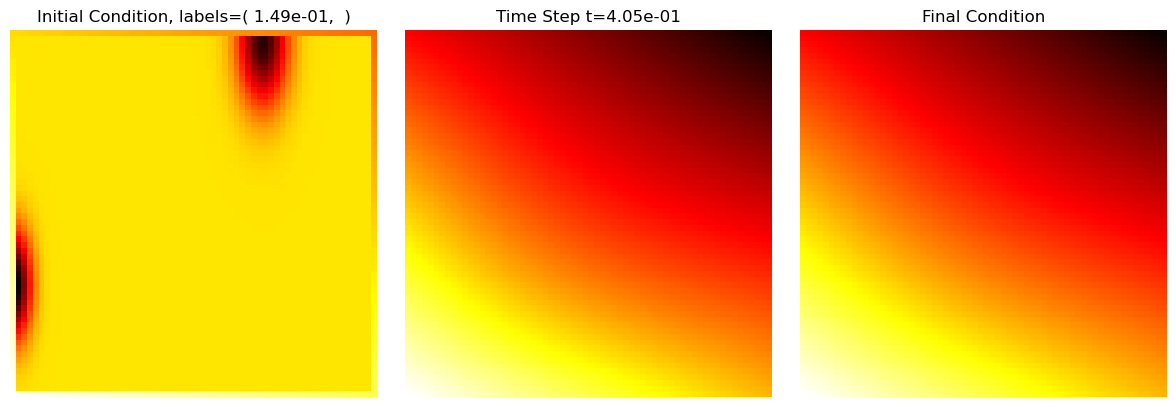

Visual inspection of data in /home/s204790/dynamical-pde-diffusion/data/heat_lineart_validate.hdf5 complete.
Visual inspection of data in /home/s204790/dynamical-pde-diffusion/data/heat_logt.hdf5...


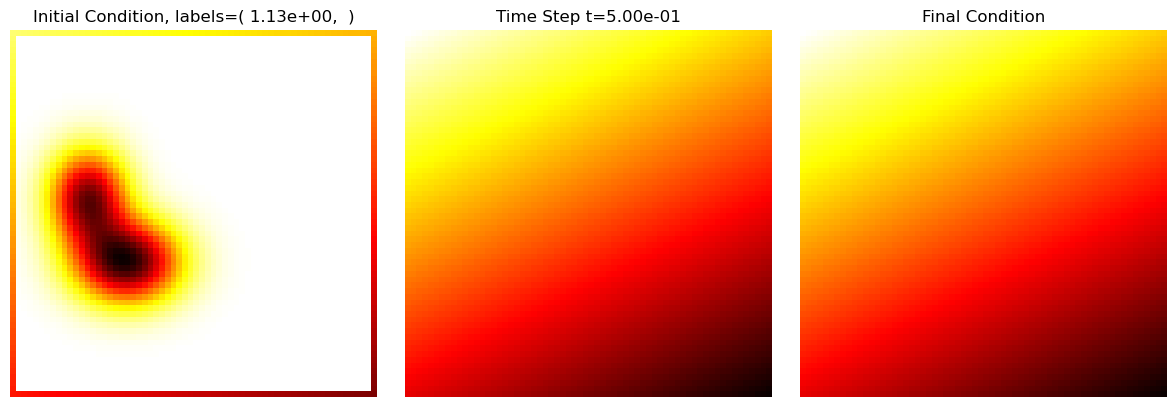

Visual inspection of data in /home/s204790/dynamical-pde-diffusion/data/heat_logt.hdf5 complete.
Visual inspection of data in /home/s204790/dynamical-pde-diffusion/data/heat_logt_validate.hdf5...


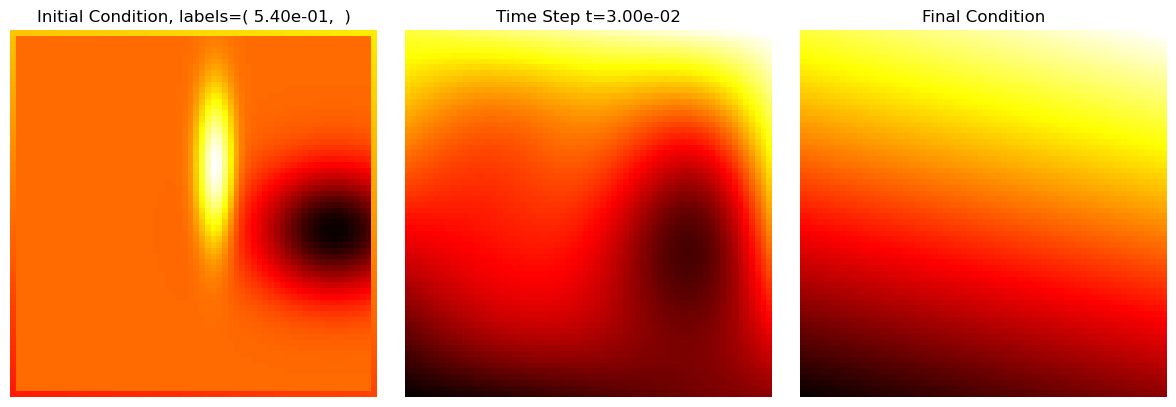

Visual inspection of data in /home/s204790/dynamical-pde-diffusion/data/heat_logt_validate.hdf5 complete.


In [37]:
# visual inspection of data samples

def plot_samples(Us, t_steps, labels):
    sample_idx = np.random.choice(Us.shape[0])
    U = Us[sample_idx]  # shape (C, H, W, T)
    lbls = labels[sample_idx]
    label_str = "( " + "".join([f"{lbl:.2e}, " for lbl in lbls]) + " )"
    mid_idx = np.random.choice(len(t_steps))
    idx_list = [0, mid_idx, -1]
    titles = [f'Initial Condition, labels={label_str}', f'Time Step t={t_steps[mid_idx]:.2e}', 'Final Condition']
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axs.flat):
        ax.imshow(U[0, :, :, idx_list[i]], cmap='hot')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

for path in all_data_paths:
    print(f"Visual inspection of data in {path}...")
    with h5py.File(path, 'r') as f:
        U = f['U'][:]         # shape (N, C, H, W, T)
        labels = f['labels'][:]  # shape (N, num_labels)
        t_steps = f['t_steps'][:]  # shape (T,)
    plot_samples(U, t_steps, labels)
    print(f"Visual inspection of data in {path} complete.")
del U, labels, t_steps

# Checking Configuration Files

The next cells serve to check the configuration files, and make sure that everything looks as intended.

In [17]:
config_dir = dpde.utils.get_repo_root() / "conf"

cfg_names = ["train", "validate"]
with initialize_config_dir(config_dir=str(config_dir), version_base=None):
    cfgs = [compose(config_name=cfg_name) for cfg_name in cfg_names]
    print(f"Configurations loaded successfully:")
for cfg, name in zip(cfgs, cfg_names):
    print(f"Configuration for {name}:")
    print(OmegaConf.to_yaml(cfg))

Configurations loaded successfully:
Configuration for train:
dataset:
  data:
    pde: heat
    name: heat_logt
    datapath: data/heat_logt.hdf5
  net:
    in_ch: 2
    label_ch: 2
  training:
    batch_size: 64
    shuffle: true
    num_epochs: 500
    learning_rate: 0.001
    weight_decay: 0.0
  sampling:
    sample_shape:
    - 2
    - 64
    - 64
    batch_size: 32
    ch_a: 1
    zeta_a: 50.0
    zeta_u: 40.0
    zeta_pde: 0.4
    num_steps: 50
    loss_func: diffusion_pde.sampling.heat_loss
model:
  name: Unet Small
  chs:
  - 32
  - 64
  - 128
  - 256
  noise_ch: 32
  sigma_data: 0.5
wandb:
  entity: philiphohwy-danmarks-tekniske-universitet-dtu
  project: dynamical-pde-diffusion
  dir: ${oc.env:REPO_ROOT,${oc.env:PWD}}/logs
  name: None
model_save_path: ${oc.env:REPO_ROOT,${hydra:runtime.cwd}}/pretrained_models

Configuration for validate:
dataset:
  data:
    pde: heat
    name: heat_logt
    datapath: data/heat_logt.hdf5
  net:
    in_ch: 2
    label_ch: 2
  training:
    ba

U min: -0.5936176776885986, max: 0.8791067004203796


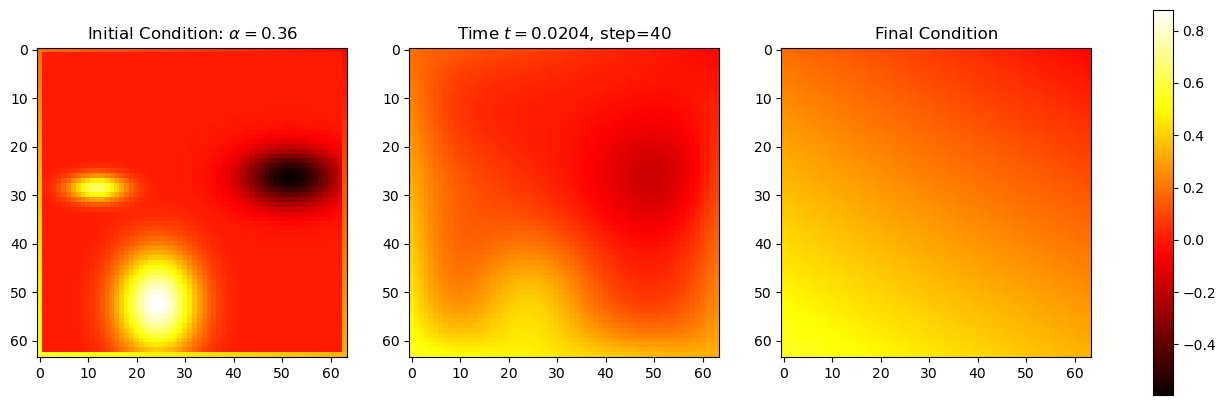

In [6]:
idx = 1
t_idx = 40  # which time step to visualize
vmin, vmax = U[idx].min(), U[idx].max()
print(f"U min: {vmin}, max: {vmax}")

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(U[idx, 0, :, :, 0], cmap='hot', vmin=vmin, vmax=vmax)
axs[0].set_title(f'Initial Condition: $\\alpha={labels[idx, 0]:.2f}$')
axs[1].imshow(U[idx, 0, :, :, t_idx], cmap='hot', vmin=vmin, vmax=vmax)
axs[1].set_title(f'Time $t={t_steps[t_idx]:.4f}$, step={t_idx}')
axs[2].imshow(U[idx, 0, :, :, -1], cmap='hot', vmin=vmin, vmax=vmax)
axs[2].set_title('Final Condition')
fig.colorbar(axs[1].images[0], ax=axs, orientation='vertical', fraction=.1)
plt.show()

In [7]:
diff = U[..., 1:] - U[..., :-1]
diff = np.permute_dims(diff, (0, 4, 1, 2, 3)).squeeze()  # shape (N, T-1, h, w)
norm_diff = np.linalg.norm(diff.reshape(diff.shape[0], diff.shape[1], -1), axis=-1)  # shape (N, T-1)
mean_norm_diff = norm_diff.mean(axis=0)  # shape (T-1,)
print(diff.shape)
print(norm_diff.shape)
print(mean_norm_diff.shape)

(800, 64, 64, 64)
(800, 64)
(64,)


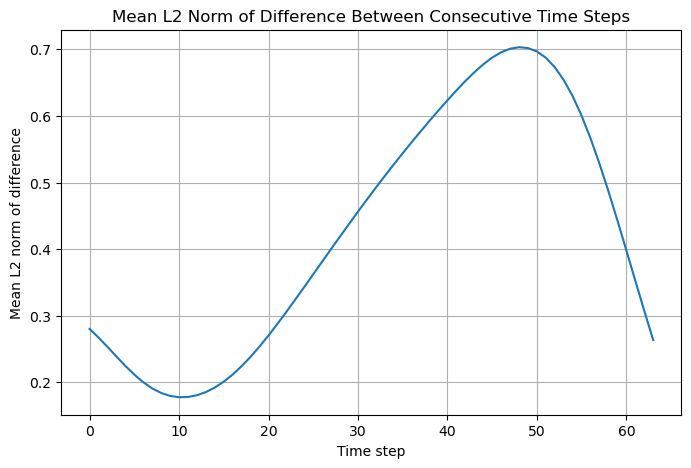

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(mean_norm_diff)
#plt.plot(norm_diff[:10].T)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Time step')
plt.ylabel('Mean L2 norm of difference')
plt.title('Mean L2 Norm of Difference Between Consecutive Time Steps')
plt.grid(True)
plt.show()

In [9]:
data_shape = A.shape[-2:]
ch_a = A.shape[1]
ch_u = U.shape[1]
N = A.shape[0]
num_tsteps = t_steps.shape[0]
label_dim = labels.shape[1]

print(f"Data shape: {data_shape}, ch_a: {ch_a}, ch_u: {ch_u}, N: {N}, num_tsteps: {num_tsteps}, label_dim: {label_dim}")

Data shape: (64, 64), ch_a: 1, ch_u: 1, N: 800, num_tsteps: 65, label_dim: 1


In [10]:
batch_size = 16

dataloader = dpde.datasets.get_dataloader(
    datapath=str(data_dir),
    batch_size=batch_size,
    shuffle=True,
)

In [11]:
X, label = next(iter(dataloader))
print(f"batches in train loader: {len(dataloader)}, samples = {len(dataloader.dataset)}")
print("X shape:", X.shape, f"Expected shape: ({batch_size}, {ch_a + ch_u}, {data_shape[0]}, {data_shape[1]})")  # Expected shape: (2, ch0 + ch1, h, w)
print("Label shape:", label.shape, f"Expected shape: ({batch_size}, {label_dim + 1})\n")

batches in train loader: 50, samples = 800
X shape: torch.Size([16, 2, 64, 64]) Expected shape: (16, 2, 64, 64)
Label shape: torch.Size([16, 2]) Expected shape: (16, 2)



In [24]:
chs = [ch_a + ch_u, 32, 64, 128, 256]

unet = dpde.models.Unet(chs, label_ch=label_dim + 1)
edm_model = dpde.models.EDMWrapper(unet)
loss = dpde.models.EDMLoss()

In [25]:
sigma = torch.ones(X.shape[0]) * 0.01

t1 = time.perf_counter()
for i in range(10):
    X1, dXdt1 =dpde.sampling.X_and_dXdt(edm_model, X, sigma, label)
t2 = time.perf_counter()
print(f"Time for 100 runs of X_and_dXdt: {t2 - t1:.4f} seconds")

t1 = time.perf_counter()
for i in range(10):
    X2, dXdt2 =dpde.sampling.X_and_dXdt_fd(edm_model, X, sigma, label, eps=1e-2)
t2 = time.perf_counter()
print(f"Time for 100 runs of X_and_dXdt_fd: {t2 - t1:.4f} seconds")

Time for 100 runs of X_and_dXdt: 0.2853 seconds
Time for 100 runs of X_and_dXdt_fd: 0.2214 seconds


In [26]:
assert torch.allclose(X1, X2, atol=1e-5), "X1 and X2 are not close!"
assert torch.allclose(dXdt1, dXdt2, atol=1e-3), "dXdt1 and dXdt2 are not close!"
print("X1 and X2 are close!")

X1 and X2 are close!


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
edm_model = edm_model.to(device)

device: cuda


In [28]:
wandb_kwargs = {
    "entity": "philiphohwy-danmarks-tekniske-universitet-dtu",
    "project": "dynamical-pde-diffusion",
    "name": "test-run2",
    "tags": ["testing", "unet", "edm"],
    "notes": "This is a test run to check if the training loop works."
}

In [29]:
"""
dpde.training.train(
    model=edm_model,
    dataloader=loader1,
    loss_fn=loss,
    device=device,
    epochs=5,
    lr=1e-4,
    weight_decay=0.0,
    wandb_kwargs=wandb_kwargs
)
"""

'\ndpde.training.train(\n    model=edm_model,\n    dataloader=loader1,\n    loss_fn=loss,\n    device=device,\n    epochs=5,\n    lr=1e-4,\n    weight_decay=0.0,\n    wandb_kwargs=wandb_kwargs\n)\n'

In [30]:
wandb_kwargs = {
    "entity": "philiphohwy-danmarks-tekniske-universitet-dtu",
    "project": "dynamical-pde-diffusion",
    "name": "test-run-validation-single-pass",
    "tags": ["testing", "unet", "edm"],
    "notes": "This is a test run to check if the validation loop works.",
    "job_type": "validation",
}

cfg_path = dpde.utils.get_repo_root() / "conf/dataset/heat_eq.yaml"
cfg = OmegaConf.load(cfg_path)
validation_cfg = cfg.validation
sampling_cfg = cfg.sampling
save_path = dpde.utils.get_repo_root() / "logs" / "validation"

In [ ]:
dpde.validation.validate_model(
    model=edm_model,
    validation_cfg=validation_cfg,
    sampling_cfg=sampling_cfg,
    wandb_kwargs=wandb_kwargs,
)

TypeError: validate_model() got an unexpected keyword argument 'save_path'